In [1]:
%matplotlib inline
import xlrd
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os as os
from itertools import product
import scipy.stats as ss
from scipy.stats import norm
from math import e
np.set_printoptions(suppress=True, linewidth=200, edgeitems=100)

# Motivation, Notes & Steps

## Motivation
1. In general, if a request is in FAMIS, we want to see how its predictor variables (such as month, type, subtype, crew, assigned to, priority, etc) affect its target variable — recorded status. 'Closed' status is what we want. Moreover, if a request is closed, we want to see:
2. how its predictor variables affect its completion time (i.e., time from the date it was received in the system to the actual completion date). Completion time is the target variable here. This is important for students' satisfaction.
3. whether the completion is before the deadline or completed late. Timeliness is the target variable here. The best case scenario is every closed request is completed before the deadline. 
4. Last but not least, after understanding how predictors affect target, we can use machine learning model to predict target from a testing data, given that the model is appropriate enough. This answers the type of questions like 'What would be the best guess of a FAMIS ticket status if the system received it in September, from Julian and its type is IS Building Access?'

This notebook can serve these goals by providing:
- Data summary and overview
- Relevant charts, plots and graphs
- Codes that execute commands for further understanding a variable
- Tables that summarize coefficients from regression models and their significance

In response to our motivation, here are the three main analyses that we will run:
- Status Insights
- Completion Time Insights
- Timeliness Insights (we won't check coefficients here)

## Note
- Multinomial Logistic Regression is the model we will use throughout this notebook, because target variables can have multiple outcomes.
- For regression we will only focus on one predictor variable and one outcome at a time. 
- If more than one predictor variable is used, for simplicity we will not take into account interaction and correlation  between them (also known as "multicollinearity").
- For machine learning we don't need to scale predictors because they are all categorical. For convenience we also keep all dummies rather than (n-1) dummies, this perfect multicollinearity doesn't hurt if our model has high training score and testing score. 
- The "Status" column is not very reliable, so we can only use the Status Insights part as a reference. 
- The "Complete By" column may be set by default, so the "Budgeted Time" column (a column we will calculate later) may also be default. Hence, we can only use the Timeliness Insights part as a reference.
- The Complete Time Insights is perhaps the most useful analysis among the three.
- For conceptual soundness of modelling and more mathematical justifications, see the FAMIS Report document. 


## Steps
For data preparation, here are some recommended steps :
1. Creating a column named "Request ID" that provides a unique identifier for each request
2. Dropping non-value columns
3. Creating "Completion Time" column (time between "Date" column and "Act. Complete Date" column)
4. Creating "Budgeted Time" column (time between "Date" column and "Complete By" column)
5. Dropping unnecessary column. Those columns are either too specific or too irrelevant to our goals
6. Dropping duplicated or unnecessary rows

For data analysis, here are the steps that we will perform:
1. If the predictor and the target are both categorical, checking chi-squared contingency to see if the predictor variable is correlated with the target variable or not (i.e, whether a change in value of the predictor results in a change in value of the target) 
2. If the predictor is categorical and the target is numerical, drawing box plots to see if the predictor variable is correlated with the target variable or not (this also helps with data visualization compared to performing one-way ANOVA)
3. Plugging in variables and extracting some preliminary results for better understanding data
4. Implementing Multinomial Logistic Regression model to quantify the effect of each categorical value of the predictor on the target
5. Interpreting the coeffcient results
5. Applying machine learning to predict target from predictors

For modelling, here are the steps:
1. Appending a testing row (this will be used later in the machine learning part) and converting categorical predictors to dummies
2. Using LabelEncoder to encode categorical outcomes to integer values
3. Creating dictionaries to look up the outcomes
4. Implementing the model and checking coefficients' significance

# Function for p-Value

## Function code
Python is poor at statistical inference and does not support p-value calculation in general in its sklearn library. One way of pulling out these p-values from logistic regression is to use the glm package in R, but it's tough to run multiple models in R at the same time. We will build a Python code for checking p-value in multinomial logistic regression model, and then test it with already built-in statistical package in Python to see if they're matched. The code is based on Wald test and matrix algebra.

In [2]:
def logit_pvalue(model, X, CAT):
    p = model.predict_proba(X)
    n = len(p)
    m = len(model.coef_[CAT]) + 1
    coefs = np.concatenate([np.array([model.intercept_[CAT]]), model.coef_[CAT]])
    x_full = np.matrix(np.insert(np.array(X), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    det = np.linalg.det(np.matrix(ans))
    if det == 0:
        p = [1, 1] 
    else:
        vcov = np.linalg.inv(np.matrix(ans))
        se = np.sqrt(np.diag(vcov))
        t =  coefs/se  
        p = (1 - norm.cdf(abs(t))) * 2
    return p

## Test for function's validity
In the above code, CAT is an abbreviation for category. The function can take different CAT values as different categorical outcomes. For example, in our logistic model, if our target variable has three outcomes (such as Low, Medium, High), then there will be three sets of coefficients, each set for each outcome (hence the term "multinomial"). If we have two predictor variables, then there would be 2 x 3 = 6 coefficients in total, not jut two. 

Basically what the model does is calculating the probability of the first outcome by the first set of coefficients, the probability of the second outcome by the second set of coefficients, etc, then comparing them. The result is simply the outcome that has the highest probability.   


We just need to specify CAT = 0 to test the function, since test data is binary.

In [3]:
CAT = 0 
x = np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1]).reshape(-1,1)
y = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1])
from sklearn.linear_model import LogisticRegression
print(logit_pvalue(LogisticRegression(C=1e30).fit(x, y), x, CAT))

[0.03773314 0.00707989]


In [4]:
import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

[0.03773005 0.00707927]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                  0.3881
Time:                        13:14:25   Log-Likelihood:                -8.4209
converged:                       True   LL-Null:                       -13.763
Covariance Type:            nonrobust   LLR p-value:                  0.001081
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6094      0.775     -2.078      0.038      -3.128      -0.091
x1             3.5553      1.320      2.693      0.007       0.968       6.143
==============================================================================
"""

The function worked well as expected!

# Data Preparation

## Data overview
Our data is mostly categorical, except time data. For these categorical data, we want to see how many rows and columns are in total, how many values are unique, and the mode (value that occurs most often).

In [5]:
famistix_df_original = pd.read_csv('FAMIS Data.csv')
famistix_df_original.head()

,MONTH,Date,ID,Initiated By,Building,Floor,Space,Cube Number,Type,SubType,...,Comments,Est. Labor Hours,Act. Labor Hours,Complete By,Asset,Procedure,Ref WO,Last Updated Date,Closed Date,Act. Complete Date
0,8,8/2/2021 7:31,207392,Hieu Le,Julian Science and Mathematics Center (2 East ...,General,General,NaN,IS - ID Card,Replace,...,ID Card Printing an ID Card\n- Name: Hieu Le\n...,NaN,NaN,8/2/2021 10:31,NaN,NaN,NaN,8/25/2021 13:03,8/25/2021 13:02,8/25/2021 13:02
1,8,8/2/2021 7:32,207393,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,General,General,NaN,IS - ID Card,Replace,...,ID Card Printing an ID Card\n- Name: Emmanuel ...,NaN,NaN,8/2/2021 10:32,NaN,NaN,NaN,8/26/2021 21:15,8/26/2021 21:14,8/26/2021 21:14
2,8,8/2/2021 7:44,207395,Cristina Osmialowski,Phi Delta Theta,General,General,NaN,IS - Building Access,Modify rights,...,"Per Chris Johnston, House Corp Trustee cl.john...",NaN,NaN,8/2/2021 10:44,NaN,NaN,NaN,8/9/2021 10:35,8/9/2021 10:33,8/9/2021 10:33
3,8,8/2/2021 8:10,207398,Evan Steffy,Julian Science and Mathematics Center (2 East ...,General,General,NaN,IS - Information Security,"Spam, Phishing �",...,SPAM\nNotification of spam with the subject of...,NaN,NaN,8/2/2021 9:10,NaN,NaN,NaN,8/2/2021 8:11,8/2/2021 8:10,8/2/2021 8:10
4,8,8/2/2021 8:37,207400,Ian McCullough,Julian Science and Mathematics Center (2 East ...,General,General,NaN,IS - ID Card,New,...,Photo Upload for DePauw ID Card\n- Rejected ID...,NaN,NaN,8/5/2021 8:37,NaN,NaN,NaN,8/2/2021 8:39,8/2/2021 8:38,8/2/2021 8:38


In [6]:
famistix_df_original.shape

(1904, 24)

In [7]:
print(famistix_df_original.describe(include=['O']))

                 Date   Initiated By  \
count            1904           1904   
unique           1738            933   
top     8/3/2021 9:00  Michele Cross   
freq               23            110   

                                                 Building    Floor    Space  \
count                                                1904     1904     1904   
unique                                                 96       14      293   
top     Julian Science and Mathematics Center (2 East ...  General  General   
freq                                                  687     1303     1303   

                 Type SubType         Crew Assigned To  Status Priority  \
count            1904    1904         1779        1904    1904     1904   
unique             15      40           21          29      10        4   
top     IS - Accounts  Modify  IS HelpDesk    HelpDesk  Closed   Medium   
freq              575     351          634         722    1670     1677   

                           

## Data cleaning and pre-processing

In [8]:
famistix_df_original.insert(0,'Request ID',range(1,1+len(famistix_df_original)))

In [9]:
famistix_df_dropna = famistix_df_original.drop_duplicates().dropna(axis='columns',thresh=10)

from datetime import datetime
complete_date_converted = pd.to_datetime(famistix_df_dropna['Act. Complete Date'])
date_converted = pd.to_datetime(famistix_df_dropna['Date'])
complete_by_converted = pd.to_datetime(famistix_df_dropna['Complete By'])

completion_time = complete_date_converted - date_converted
budgeted_time = complete_by_converted - date_converted

famistix_df_modified = famistix_df_dropna.join(budgeted_time.rename('Budgeted Time'))
famistix_df_withnewcol = famistix_df_modified.join(completion_time.rename('Completion Time'))
famistix_df_withnewcol['Budgeted Time'] = pd.to_numeric(famistix_df_withnewcol['Budgeted Time'],downcast='integer')/(8.64*(10**13))*24
famistix_df_withnewcol['Completion Time'] = pd.to_numeric(famistix_df_withnewcol['Completion Time'],downcast='integer')/(8.64*(10**13))*24

famistix_df_withnewcol.drop(['ID','Floor','Space','Comments','Closed Date'],axis='columns',inplace=True)
famistix_df_withnewcol['Crew'] = famistix_df_withnewcol['Crew'].astype(str)
famistix_df_withnewcol.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Status,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time
0,1,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667
1,2,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000
2,3,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Closed,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667
3,4,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Closed,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000
4,5,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Closed,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667


In [10]:
famistix_df_withnewcol.shape

(1904, 16)

We can focuse more on status column by: 
- seeing how many requests in each status, and
- dropping those that account for minimal percentage of total.

In [11]:
status_df = famistix_df_withnewcol.groupby(['Status']).agg({'Request ID':'count'}).reset_index()
status_df.rename(columns={'Request ID':'Count'},inplace=True)
status_df['Percentage'] = status_df[['Count']]/status_df[['Count']].sum()*100
status_df

,Status,Count,Percentage
0,Canceled,5,0.262605
1,Closed,1670,87.710084
2,Declined,1,0.052521
3,In-Planning,21,1.102941
4,On Hold,51,2.678571
5,Open,110,5.777311
6,Pending,1,0.052521
7,Ready for Scheduling,3,0.157563
8,Scheduled,40,2.100840
9,Work Complete,2,0.105042


## Cleaned data No. 1: famistix_df_clean
Now we can clean unnecessary status. After this step the data is ready for Status Insights part. 

In [12]:
df = famistix_df_withnewcol
famistix_df_clean1 = df[(df['Status'] == 'Closed') | (df['Status'] == 'In-Planning') | (df['Status'] == 'Open') | (df['Status'] == 'Scheduled') | (df['Status'] == 'On Hold')]
famistix_df_clean = famistix_df_clean1.reset_index(drop=True)
famistix_df_clean.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Status,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time
0,1,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667
1,2,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000
2,3,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Closed,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667
3,4,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Closed,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000
4,5,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Closed,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667


In [13]:
famistix_df_clean.shape

(1892, 16)

In [21]:
famistix_df_clean.to_csv('FAMIS Status Analysis.csv')

Here is the new percentage table of status:

In [14]:
status_df_new = famistix_df_clean.groupby(['Status']).agg({'Request ID':'count'}).reset_index()
status_df_new.rename(columns={'Request ID':'Count'},inplace=True)
status_df_new['Percentage'] = status_df_new[['Count']]/status_df_new[['Count']].sum()*100
status_df_new

,Status,Count,Percentage
0,Closed,1670,88.266385
1,In-Planning,21,1.109937
2,On Hold,51,2.695560
3,Open,110,5.813953
4,Scheduled,40,2.114165


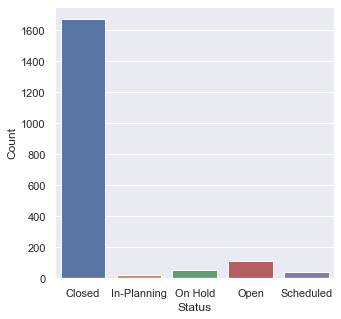

In [2376]:
sns.barplot(x='Status',y='Count',data=status_df_new)
sns.set(rc={"figure.figsize":(5, 2)}) 

## Cleaned data No. 2: famistix_df_neat & famistix_df_neatbin
All time unit is hour.

We will see that there are some negative budgeted time and negative completion time even the status is fixed at "Closed". This is probably due to the fact that there are some requests that were already done, and some requests that don't have a recorded actual complete date, or a combination of both. For convenience, we will only use requests that have positive budgeted time (i.e., "true request") and positive completion time. 

We need to further clean these negative entries.

In [15]:
famistix_df_neat1 = famistix_df_clean[(famistix_df_clean['Status'] == 'Closed')]
famistix_df_neat1[['Budgeted Time','Completion Time']].describe()

,Budgeted Time,Completion Time
count,1.670000e+03,1670.000000
mean,-1.554489e+03,-4.886257
std,6.269686e+04,612.656514
min,-2.562048e+06,-16702.350000
25%,2.400000e+01,0.016667
50%,2.400000e+01,0.183333
75%,7.200000e+01,28.216667
max,7.680000e+02,1010.333333


In [16]:
famistix_df_neat2 = famistix_df_neat1[(famistix_df_neat1['Budgeted Time'] >= 0) & (famistix_df_neat1['Completion Time'] >= 0)]
famistix_df_neat3 = famistix_df_neat2.drop(['Status'],axis='columns')
famistix_df_neat = famistix_df_neat3.reset_index(drop=True)
famistix_df_neat.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time
0,1,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667
1,2,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000
2,3,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667
3,4,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000
4,5,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667


In [17]:
famistix_df_neat.shape

(1539, 15)

We can see that the 1904-row original data is reduced to only 1539-row data now. That means we only use around 80% of the total requests for Completion Time Insights part, even though "Closed" status accounts for 88% of total data.

Here is the new summary table for Budgeted Time and Completion Time:

In [18]:
famistix_df_neat[['Budgeted Time','Completion Time']].describe()

,Budgeted Time,Completion Time
count,1539.000000,1539.000000
mean,36.487199,52.942214
std,37.483474,121.745237
min,0.000000,0.000000
25%,24.000000,0.016667
50%,24.000000,0.550000
75%,72.000000,41.275000
max,768.000000,1010.333333


Since "Completion Time" is numerical data, we can choose between linear regression (or Ridge or LASSO regression) and logistic regression for our modelling part. However, it was tested that linear regression and other numerical regression perform poorly, because predictors are all categorial but target is numerical. Therefore, we will stick with multinomial logistic regression. But first we need to categorize ("bin") data. The bins are:
1. Very Short (less than 1 hour to complete)
2. Short (between 1 and 24 hours)
2. Low Medium  (between 1 days and 3 days)
3. High Medium (between 3 days and a week)
4. Long (more than a week)

In [22]:
bins = [-0.01, 1, 24, 72, 168, famistix_df_neat['Completion Time'].max()]
group_names = ['Very Short','Short','Low Medium','High Medium','Long']
Time_CAT_Series = pd.cut(famistix_df_neat['Completion Time'], bins, labels=group_names)
Time_CAT_Series1 = pd.DataFrame(Time_CAT_Series).rename(columns = {'Completion Time':'Completion Time CAT'}).reset_index(drop=True)
famistix_df_neatbin = famistix_df_neat.join(Time_CAT_Series1)
famistix_df_neatbin.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time,Completion Time CAT
0,1,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667,Long
1,2,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000,Long
2,3,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667,Long
3,4,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000,Very Short
4,5,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667,Very Short


In [20]:
famistix_df_ctime = famistix_df_neatbin.rename(columns={'Completion Time CAT':'ctime'})
famistix_df_ctime.to_csv('FAMIS Completion Time Analysis.csv')

Here is the percentage table of completion time categories:

In [23]:
Time_CAT_df = famistix_df_neatbin.groupby(['Completion Time CAT']).agg({'Request ID':'count'}).reset_index()
Time_CAT_df.rename(columns={'Request ID':'Count'},inplace=True)
Time_CAT_df['Percentage'] = Time_CAT_df[['Count']]/Time_CAT_df[['Count']].sum()*100
Time_CAT_df

,Completion Time CAT,Count,Percentage
0,Very Short,808,52.501624
1,Short,276,17.933723
2,Low Medium,156,10.136452
3,High Medium,155,10.071475
4,Long,144,9.356725


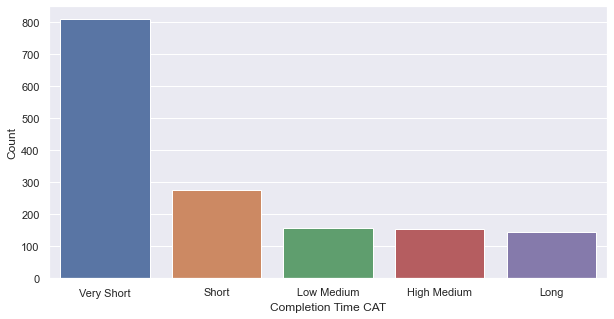

In [2887]:
sns.barplot(x='Completion Time CAT',y='Count',data=Time_CAT_df)
sns.set(rc={"figure.figsize":(5,2)}) 

## Cleaned data No. 3: famistix_df_timely
This data is for the Timeliness Insights part.

In [24]:
timely_series = pd.DataFrame(np.where(famistix_df_neat['Budgeted Time'] >= famistix_df_neat['Completion Time'], 'On-time', 'Late'))
timely_series1 = timely_series.rename(columns = {0:'Timeliness'})
famistix_df_timely = famistix_df_neat.join(timely_series1)
famistix_df_timely.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time,Timeliness
0,1,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667,Late
1,2,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000,Late
2,3,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667,Late
3,4,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000,On-time
4,5,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667,On-time


In [25]:
timely_df = famistix_df_timely.groupby(['Timeliness']).agg({'Request ID':'count'}).reset_index()
timely_df.rename(columns={'Request ID':'Count'},inplace=True)
timely_df['Percentage'] = timely_df[['Count']]/timely_df[['Count']].sum()*100
timely_df

,Timeliness,Count,Percentage
0,Late,470,30.539311
1,On-time,1069,69.460689


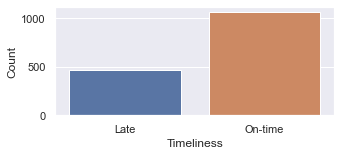

In [2604]:
sns.barplot(x='Timeliness',y='Count',data=timely_df)
sns.set(rc={"figure.figsize":(1,2)}) 

# Status Insights

## Chi-squared contingency


In [26]:
var1=('MONTH','Initiated By','Building','Type','SubType','Crew','Assigned To','Priority')
var2=("Status",)
varprod = list(product(var2, var1))
varprod

[('Status', 'MONTH'),
 ('Status', 'Initiated By'),
 ('Status', 'Building'),
 ('Status', 'Type'),
 ('Status', 'SubType'),
 ('Status', 'Crew'),
 ('Status', 'Assigned To'),
 ('Status', 'Priority')]

In [27]:
result = []
for i in varprod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
                            famistix_df_clean[i[0]], famistix_df_clean[i[1]])))[1]))
result

[('Status', 'MONTH', 3.5812223085481323e-07),
 ('Status', 'Initiated By', 1.0),
 ('Status', 'Building', 1.787564885028547e-14),
 ('Status', 'Type', 1.5915976182377221e-34),
 ('Status', 'SubType', 1.6710558655270897e-52),
 ('Status', 'Crew', 7.297524253774426e-134),
 ('Status', 'Assigned To', 2.384972685299021e-119),
 ('Status', 'Priority', 0.02408071640002011)]

In [28]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
chi_test_output.pivot(index='var1', columns='var2', values='coeff')

var2,Assigned To,Building,Crew,Initiated By,MONTH,Priority,SubType,Type
var1,,,,,,,,
Status,2.384973e-119,1.787565e-14,7.297524e-134,1.0,3.581222e-07,0.024081,1.671056e-52,1.591598e-34


Surprisingly, priority of a request does not strongly correlate with its final status compared to other variables (p value is a bit high, even though still less than 0.05). Moreover, the person who initiated the request is irrelevant to the request's status.

In short, these seven predictors are correlated with the target "Status":
1. "MONTH"
2. "Building"
3. "Type"
4. "SubType"
5. "Crew"
6. "Assigned To"
7. "Priority".

## Plugging in data and extracting results
A natural concern is to see the distribution of status across a specific category/sub-category.

In [1715]:
pred_focus_status = input('Input the predictor you want to examine ("MONTH", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): ')

Input the predictor you want to examine ("MONTH", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): Crew


In [1716]:
np.unique(famistix_df_clean[pred_focus_status])

array(['IS Accounts', 'IS Application Services', 'IS Building Access', 'IS CS Gold Hardware', 'IS Communications', 'IS Desktop Support', 'IS FITS', 'IS HelpDesk', 'IS ID Card', 'IS ID Card Printing',
       'IS IT Assessment', 'IS InfoSec', 'IS Meal Plan', 'IS Media Services', 'IS Moodle', 'IS Network', 'IS Printing', 'IS Procurement & Licensing', 'IS Scheduled', 'IS Training', 'IS Wiring',
       'nan'], dtype=object)

In [1717]:
subpred_focus_status = input('Input one of the above sub-categories that you want to examine: ')

Input one of the above sub-categories that you want to examine: IS Printing


In [1718]:
extract_df_status= famistix_df_clean[(famistix_df_clean[pred_focus_status] == subpred_focus_status)].groupby(['Status']).agg({'Request ID':'count'}).reset_index()
extract_df_status.rename(columns={'Request ID':'Count'},inplace=True)
extract_df_status['Percentage'] = extract_df_status[['Count']]/extract_df_status[['Count']].sum()*100
print('This is the status distribution of sub-category',subpred_focus_status,'in',pred_focus_status)
print(extract_df_status[['Count']].sum())
extract_df_status

This is the status distribution of sub-category IS Printing in Crew
Count    15
dtype: int64


,Status,Count,Percentage
0,Closed,10,66.666667
1,Open,2,13.333333
2,Scheduled,3,20.000000


## Modelling

### Appending a testing row and converting categorical data to dummies 

In [29]:
status_month_input = input('Input month: ')
status_building_input = input('Input building: ')
status_type_input = input('Input type: ')
status_subtype_input = input('Input subtype: ')
status_crew_input = input('Input crew: ')
status_assigned_to_input = input('Input assigned to: ')
status_priority_input = input('Input priority: ')

Input month: 10
Input building: Julian Science and Mathematics Center (2 East Hanna Street)
Input type: IS - Core Administrative Systems
Input subtype: e-Services
Input crew: IS Application Services
Input assigned to: Dugan
Input priority: Medium


In [30]:
status_input_df = pd.DataFrame({'MONTH':[status_month_input],'Building':[status_building_input],'Type':[status_type_input],'SubType':[status_subtype_input],
                         'Crew':[status_crew_input],'Assigned To':[status_assigned_to_input],'Priority':[status_priority_input]})
famistix_df_cleannew = pd.concat([famistix_df_clean, status_input_df]).reset_index(drop=True)
famistix_df_cleannew

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Status,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time
0,1.0,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,5.575167e+02
1,2.0,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,5.897000e+02
2,3.0,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Closed,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,1.708167e+02
3,4.0,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Closed,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000e+00
4,5.0,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Closed,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,1.666667e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888,1901.0,10,10/18/2021 12:00,John Schuller,Vernon E. Jordan Jr. Hall (220 East Olive Street),IS - General,Other,IS HelpDesk,HelpDesk,Closed,Medium,10/19/2021 12:00,10/18/2021 12:01,10/18/2021 12:00,24.0,0.000000e+00
1889,1902.0,10,10/18/2021 12:52,Duc Vu,Mason Hall (402 Anderson Street),IS - Software,Troubleshooting,IS HelpDesk,HelpDesk,On Hold,Medium,10/19/2021 12:52,10/18/2021 13:31,NaN,24.0,-2.562048e+06
1890,1903.0,10,10/18/2021 13:09,Michele Flint,Studebaker Building (313 South Locust Street),IS - Accounts,New,IS Accounts,ID Card,Open,Medium,10/21/2021 13:09,10/18/2021 13:56,NaN,72.0,-2.562048e+06
1891,1904.0,10,10/18/2021 13:29,Teresa Judy,Emison Building (204 East Seminary Street),IS - Accounts,Modify,IS Accounts,Timberman,Open,Medium,10/19/2021 13:29,10/18/2021 13:29,NaN,24.0,-2.562048e+06


In [31]:
dummies1 = pd.get_dummies(famistix_df_cleannew['MONTH'])
famistix_df_model1 = pd.concat([famistix_df_cleannew, dummies1], axis='columns')

dummies1 = pd.get_dummies(famistix_df_cleannew['Building'])
famistix_df_model1 = pd.concat([famistix_df_model1, dummies1], axis = 'columns')

dummies1 = pd.get_dummies(famistix_df_cleannew['Type'])
famistix_df_model1 = pd.concat([famistix_df_model1, dummies1], axis = 'columns')

dummies1 = pd.get_dummies(famistix_df_cleannew['SubType'])
famistix_df_model1 = pd.concat([famistix_df_model1, dummies1], axis = 'columns')

dummies1 = pd.get_dummies(famistix_df_cleannew['Crew'])
famistix_df_model1 = pd.concat([famistix_df_model1, dummies1], axis = 'columns')

dummies1 = pd.get_dummies(famistix_df_cleannew['Assigned To'])
famistix_df_model1 = pd.concat([famistix_df_model1, dummies1], axis = 'columns')

dummies1 = pd.get_dummies(famistix_df_cleannew['Priority'])
famistix_df_model1 = pd.concat([famistix_df_model1, dummies1], axis = 'columns')

status_testing_row = famistix_df_model1.iloc[[len(famistix_df_model1)-1],:]
famistix_df_model1 = famistix_df_model1.iloc[:-1 , :]
famistix_df_model1.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Status,...,Pritchard,Puckett,Smith,Timberman,Weber-Brueggeman,Wilson,High,IS Emergency,Low,Medium
0,1.0,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,...,0,0,0,0,0,0,0,0,0,1
1,2.0,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Closed,...,0,0,0,0,0,0,0,0,0,1
2,3.0,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Closed,...,0,0,0,0,0,0,0,0,0,1
3,4.0,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Closed,...,0,0,0,0,0,0,0,0,0,1
4,5.0,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Closed,...,0,0,0,0,0,0,0,0,0,1


### Using LabelEncoder to encode target variable 
These integers will index the outcome by integers as well, so for example, if we have a matrix of coefficients, we don't need to worry about what row corresponds to what outcome.

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 

le.fit(famistix_df_model1['Status'])  
print(le.classes_) 

famistix_df_model1['Status Encoded'] = le.transform(famistix_df_model1['Status']) 

['Closed' 'In-Planning' 'On Hold' 'Open' 'Scheduled']


### Creating dictionaries to look up the outcomes

In [33]:
famistix_df_model1_lookup = dict(zip(famistix_df_model1['Status'].unique(), famistix_df_model1['Status Encoded'].unique()))  
famistix_df_model1_lookup

{'Closed': 0, 'Open': 3, 'Scheduled': 4, 'In-Planning': 1, 'On Hold': 2}

In [34]:
famistix_df_model1_lookupreverse = dict(zip(famistix_df_model1['Status Encoded'].unique(), famistix_df_model1['Status'].unique()))  
famistix_df_model1_lookupreverse

{0: 'Closed', 3: 'Open', 4: 'Scheduled', 1: 'In-Planning', 2: 'On Hold'}

### Implementing models and checking coefficients
We will run multiple logistic regression models at the same. Each model will have one predictor variable. We will then check the coefficient of the predictor to see if it's significant or not.

The code below runs every possible logistic regression models at the same time (a model comprising one predictor and our target "Status Encoded"). It checks statistical significance with significance level 0.05. The code may take a long time to run so be patient.

In [1633]:
from sklearn.linear_model import LogisticRegression

predictor=[]
model=[]
X_list=[]

for i in range(16,225):
    X = famistix_df_model1.iloc[:,[i]]
    y = famistix_df_model1['Status Encoded']
    predictor=predictor+list([X.columns])
    X_list = X_list + list([X])
    lr = LogisticRegression(C=1e30, solver='lbfgs', multi_class='multinomial', random_state=1)
    model = model + list([lr.fit(X,y)])
    
status_df = pd.DataFrame(predictor,columns=['predictor'])
status_df['model'] = pd.Series(model)
status_df['X'] = pd.Series(X_list)

for i in list(famistix_df_model1_lookup.keys()):
    CAT = famistix_df_model1_lookup[i]
    status_df['raw intercept '+i] = [j.intercept_[CAT] for j in status_df['model']]
    status_df['pvalue intercept '+i] = [logit_pvalue(j,k,CAT)[0] for (j,k) in zip(status_df['model'],status_df['X'])] 
    status_df['raw coefficient '+i] = [j.coef_[CAT][0] for j in status_df['model']]
    status_df['pvalue coefficient '+i] = [logit_pvalue(j,k,CAT)[1] for (j,k) in zip(status_df['model'],status_df['X'])]
    
status_df = status_df[(status_df['pvalue coefficient Open'] < 0.05) | (status_df['pvalue coefficient Closed'] < 0.05) | 
                      (status_df['pvalue coefficient Scheduled'] < 0.05) | (status_df['pvalue coefficient In-Planning'] < 0.05) | (status_df['pvalue coefficient On Hold'] < 0.05)]
status_df.drop(['model','X'],axis='columns',inplace=True)
status_df

,predictor,raw intercept Closed,pvalue intercept Closed,raw coefficient Closed,pvalue coefficient Closed,raw intercept Open,pvalue intercept Open,raw coefficient Open,pvalue coefficient Open,raw intercept Scheduled,...,raw coefficient Scheduled,pvalue coefficient Scheduled,raw intercept In-Planning,pvalue intercept In-Planning,raw coefficient In-Planning,pvalue coefficient In-Planning,raw intercept On Hold,pvalue intercept On Hold,raw coefficient On Hold,pvalue coefficient On Hold
41,Asbury Hall (100 East Seminary Street),2.882023,0.000000e+00,2.315063,4.134119e-02,0.127795,0.590814,3.063914,6.933976e-03,-0.923435,...,3.555765,1.727765e-03,-1.511305,2.039344e-10,2.756769,1.512657e-02,-0.575078,0.015543,-11.691511,0.000000e+00
49,Center for Diversity & Inclusion (5 West Hanna ),2.873813,0.000000e+00,4.428397,8.993911e-05,0.159198,0.503516,-10.240226,0.000000e+00,-0.877725,...,5.982639,1.218260e-07,-1.545792,8.270673e-11,6.650961,4.059152e-09,-0.609494,0.010432,-6.821771,1.611228e-09
76,Olin Biological Sciences Building (1 East Hann...,2.881549,0.000000e+00,1.745788,3.337788e-02,0.156319,0.521865,2.073193,1.152049e-02,-0.862236,...,2.397964,3.474745e-03,-1.581479,9.193579e-11,3.810610,3.420438e-06,-0.594153,0.014918,-10.027554,0.000000e+00
85,Robert G. Bottoms Alumni & Development Center ...,2.878283,0.000000e+00,2.082636,7.528776e-02,0.093966,0.692487,3.508993,2.727316e-03,-0.857550,...,2.262498,5.331990e-02,-1.525394,1.362255e-10,2.930845,1.230991e-02,-0.589305,0.013129,-10.784972,0.000000e+00
87,Seminary Street Apartments (301 East Seminary ...,2.872119,0.000000e+00,6.628679,1.081757e-07,0.153243,0.519565,-8.150459,6.488587e-11,-0.858405,...,-3.981080,1.419979e-03,-1.551445,7.027778e-11,10.358486,0.000000e+00,-0.615513,0.009689,-4.855626,9.964829e-05
102,IS - Building Access,2.855482,0.000000e+00,2.893418,7.890278e-03,0.107122,0.652670,3.377492,1.927352e-03,-0.854408,...,2.258896,3.806883e-02,-1.522140,1.605138e-10,2.927603,7.185613e-03,-0.586056,0.013808,-11.457410,0.000000e+00
108,IS - Hardware,3.057490,0.000000e+00,-0.820743,9.409732e-02,0.165858,0.602060,0.461303,3.467168e-01,-0.956258,...,0.890577,6.927558e-02,-1.890616,2.783185e-09,1.642484,8.070267e-04,-0.376474,0.236574,-2.173621,9.258690e-06
111,IS - Media Services,2.874435,0.000000e+00,2.012251,6.825775e-02,0.158346,0.505773,1.809884,1.010184e-01,-0.912856,...,3.287977,2.889676e-03,-1.528195,1.343989e-10,2.804715,1.104243e-02,-0.591730,0.012894,-9.914828,0.000000e+00
114,IS - Software,2.947313,0.000000e+00,-0.323251,5.452226e-01,0.049677,0.855752,0.842040,1.150718e-01,-0.854796,...,0.280168,6.000634e-01,-1.673092,9.216767e-10,1.098600,3.978935e-02,-0.469101,0.086052,-1.897558,3.836176e-04
133,Move,2.898665,0.000000e+00,1.231964,3.444660e-01,0.159359,0.502342,2.430853,6.212882e-02,-0.958345,...,4.059891,1.836594e-03,-1.517858,1.666305e-10,3.010432,2.088095e-02,-0.581821,0.014320,-10.733140,2.220446e-16


In [1634]:
for i in list(famistix_df_model1_lookup.keys()):
    status_df['intercept '+i] = [j if k < 0.05 else 0 for (j,k) in zip(status_df['raw intercept '+i], status_df['pvalue intercept '+i])]
    status_df['coefficient '+i] = [j if k < 0.05 else 0 for (j,k) in zip(status_df['raw coefficient '+i], status_df['pvalue coefficient '+i])]
for i in list(famistix_df_model1_lookup.keys()):
    status_df.drop(['raw coefficient '+i,'pvalue coefficient '+i],axis='columns',inplace=True)
    status_df.drop(['raw intercept '+i,'pvalue intercept '+i],axis='columns',inplace=True)
status_df = status_df.reset_index(drop=True)
status_df

,predictor,intercept Closed,coefficient Closed,intercept Open,coefficient Open,intercept Scheduled,coefficient Scheduled,intercept In-Planning,coefficient In-Planning,intercept On Hold,coefficient On Hold
0,Asbury Hall (100 East Seminary Street),2.882023,2.315063,0,3.063914,-0.923435,3.555765,-1.511305,2.756769,-0.575078,-11.691511
1,Center for Diversity & Inclusion (5 West Hanna ),2.873813,4.428397,0,-10.240226,-0.877725,5.982639,-1.545792,6.650961,-0.609494,-6.821771
2,Olin Biological Sciences Building (1 East Hann...,2.881549,1.745788,0,2.073193,-0.862236,2.397964,-1.581479,3.810610,-0.594153,-10.027554
3,Robert G. Bottoms Alumni & Development Center ...,2.878283,0.000000,0,3.508993,-0.857550,0.000000,-1.525394,2.930845,-0.589305,-10.784972
4,Seminary Street Apartments (301 East Seminary ...,2.872119,6.628679,0,-8.150459,-0.858405,-3.981080,-1.551445,10.358486,-0.615513,-4.855626
5,IS - Building Access,2.855482,2.893418,0,3.377492,-0.854408,2.258896,-1.522140,2.927603,-0.586056,-11.457410
6,IS - Hardware,3.057490,0.000000,0,0.000000,-0.956258,0.000000,-1.890616,1.642484,0.000000,-2.173621
7,IS - Media Services,2.874435,0.000000,0,0.000000,-0.912856,3.287977,-1.528195,2.804715,-0.591730,-9.914828
8,IS - Software,2.947313,0.000000,0,0.000000,-0.854796,0.000000,-1.673092,1.098600,0.000000,-1.897558
9,Move,2.898665,0.000000,0,0.000000,-0.958345,4.059891,-1.517858,3.010432,-0.581821,-10.733140


In [1676]:
status_main_df = pd.DataFrame()
for i in list(famistix_df_model1_lookup.keys()):
    status_main_df[i] = ["{:,.2f}".format(e**(j1+j2)*100/(e**(j3+j4)+e**(j5+j6)+e**(j7+j8)+e**(j9+j10)+e**(j11+j12))) for (j1,j2,j3,j4,j5,j6,j7,j8,j9,j10,j11,j12) in zip(status_df['intercept '+i],status_df['coefficient '+i],status_df['intercept Closed'],status_df['coefficient Closed'],status_df['intercept Open'], status_df['coefficient Open'], status_df['intercept Scheduled'],status_df['coefficient Scheduled'],status_df['intercept In-Planning'],status_df['coefficient In-Planning'],status_df['intercept On Hold'],status_df['coefficient On Hold'])]
status_main_df['Predictor'] = pd.Series(status_df['predictor'])
status_main_df['Observation'] = 'Appear'
    
status_append_df = pd.DataFrame()
for i in list(famistix_df_model1_lookup.keys()):
    status_append_df[i] = ["{:,.2f}".format(e**(j1)*100/(e**(j2)+e**(j3)+e**(j4)+e**(j5)+e**(j6))) for (j1,j2,j3,j4,j5,j6) in zip(status_df['intercept '+i],status_df['intercept Closed'],status_df['intercept Open'],status_df['intercept Scheduled'],status_df['intercept In-Planning'],status_df['intercept On Hold'])]
status_append_df['Predictor'] = pd.Series(status_df['predictor'])
status_append_df['Observation'] = 'Gone'

status_combine_df = pd.concat([status_main_df,status_append_df])

status_combine_df['Category'] = ['MONTH' if np.isin(x,famistix_df_clean['MONTH']) else
                        'Building' if np.isin(x,famistix_df_clean['Building']) else
                        'Type' if np.isin(x,famistix_df_clean['Type']) else
                        'SubType' if np.isin(x,famistix_df_clean['SubType']) else
                        'Crew' if np.isin(x,famistix_df_clean['Crew']) else
                        'Assigned To' if np.isin(x,famistix_df_clean['Assigned To']) else
                        'Priority' if np.isin(x,famistix_df_clean['Priority']) else
                        None for x in status_combine_df['Predictor']]
status_combine_df

,Closed,Open,Scheduled,In-Planning,On Hold,Predictor,Observation,Category
0,82.33,9.75,6.33,1.58,0.00,Asbury Hall (100 East Seminary Street),Appear,Building
1,81.82,0.00,9.09,9.09,0.00,Center for Diversity & Inclusion (5 West Hanna ),Appear,Building
2,82.37,6.40,3.74,7.49,0.00,Olin Biological Sciences Building (1 East Hann...,Appear,Building
3,31.93,59.99,0.76,7.32,0.00,Robert G. Bottoms Alumni & Development Center ...,Appear,Building
4,66.68,0.00,0.00,33.32,0.00,Seminary Street Apartments (301 East Seminary ...,Appear,Building
5,89.34,8.34,1.16,1.16,0.00,IS - Building Access,Appear,Type
6,90.33,4.25,1.63,3.31,0.48,IS - Hardware,Appear,Type
7,53.60,3.03,32.53,10.84,0.00,IS - Media Services,Appear,Type
8,89.91,4.72,2.01,2.66,0.71,IS - Software,Appear,Type
9,39.60,2.18,48.51,9.71,0.00,Move,Appear,SubType


In [1677]:
status_result_df = status_combine_df.melt(id_vars=['Predictor','Observation','Category'], value_vars=['Closed','Open','Scheduled','In-Planning','On Hold'])
status_result_df = status_result_df.rename(columns={'variable':'Status','value':'Expected Probability'})
status_result_df

,Predictor,Observation,Category,Status,Expected Probability
0,Asbury Hall (100 East Seminary Street),Appear,Building,Closed,82.33
1,Center for Diversity & Inclusion (5 West Hanna ),Appear,Building,Closed,81.82
2,Olin Biological Sciences Building (1 East Hann...,Appear,Building,Closed,82.37
3,Robert G. Bottoms Alumni & Development Center ...,Appear,Building,Closed,31.93
4,Seminary Street Apartments (301 East Seminary ...,Appear,Building,Closed,66.68
...,...,...,...,...,...
255,Nuss,Gone,Assigned To,On Hold,2.74
256,Parrish,Gone,Assigned To,On Hold,2.74
257,Pritchard,Gone,Assigned To,On Hold,2.78
258,Puckett,Gone,Assigned To,On Hold,2.77


In [1678]:
status_result_df.to_csv('Predictor and Logistic Probability for Status.csv', index=False)

In [1681]:
status_check_df = famistix_df_clean.melt(id_vars=['Request ID','Status'], value_vars=['MONTH','Building','Type','SubType','Crew','Assigned To','Priority'])
status_check_df = status_check_df.rename(columns={'variable':'Category','value':'Predictor'})
status_check_df['Predictor'] = status_check_df['Predictor'].astype(str)
status_check_df

,Request ID,Status,Category,Predictor
0,1,Closed,MONTH,8
1,2,Closed,MONTH,8
2,3,Closed,MONTH,8
3,4,Closed,MONTH,8
4,5,Closed,MONTH,8
...,...,...,...,...
13239,1900,Closed,Priority,Medium
13240,1901,Closed,Priority,Medium
13241,1902,On Hold,Priority,Medium
13242,1903,Open,Priority,Medium


In [1682]:
status_check_df.to_csv('Predictor for Status.csv',index=False)

## Interpreting results
If we focus on the outcome "Open", for example, a request that belongs to "IS - Building Access" type or belongs to "IS Procurement & Licensing" crew will be more likely to be "Open", because coefficient is positive, whereas a request that is assigned to "Puckett" will be more likely not to be "Open", because coefficient is negative. We can check these conclusions by comparing the probabilities when predictor = 1 and predictor = 0. 

## Predicting status

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.9, solver='lbfgs', multi_class='multinomial', max_iter=1000000, random_state=1)
X = famistix_df_model1.iloc[:,16:225]
y = famistix_df_model1['Status Encoded']
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1, stratify=y)
lr.fit(X_train, y_train)
print('Training accuracy:', lr.score(X_train, y_train))
print('Test accuracy:', lr.score(X_test, y_test))

Training accuracy: 0.9116314199395771
Test accuracy: 0.9119718309859155


In [36]:
pred = lr.predict(status_testing_row.iloc[:,16:225])[0]
print('Status prediction for testing row:\n', famistix_df_model1_lookupreverse[pred])
print('Probability prediction for testing row:\n', lr.predict_proba(status_testing_row.iloc[:,16:225])[0])
print('Column order:\n',famistix_df_model1_lookupreverse)

Status prediction for testing row:
 Closed
Probability prediction for testing row:
 [0.98819913 0.00196206 0.00213102 0.00482275 0.00288505]
Column order:
 {0: 'Closed', 3: 'Open', 4: 'Scheduled', 1: 'In-Planning', 2: 'On Hold'}


# Completion Time Insights

## Box plot for correlation

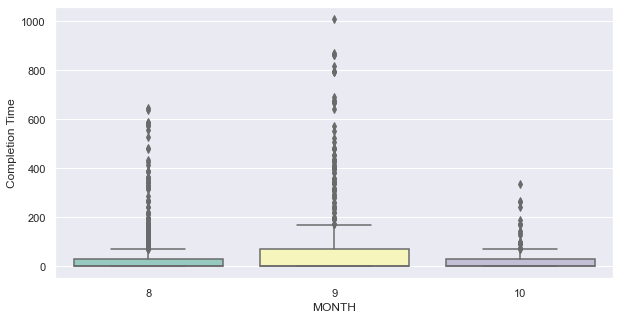

In [592]:
sns.boxplot(x='MONTH', y='Completion Time', data=famistix_df_neat, palette='Set3')
sns.set(rc={"figure.figsize":(2,1)}) 
plt.show()

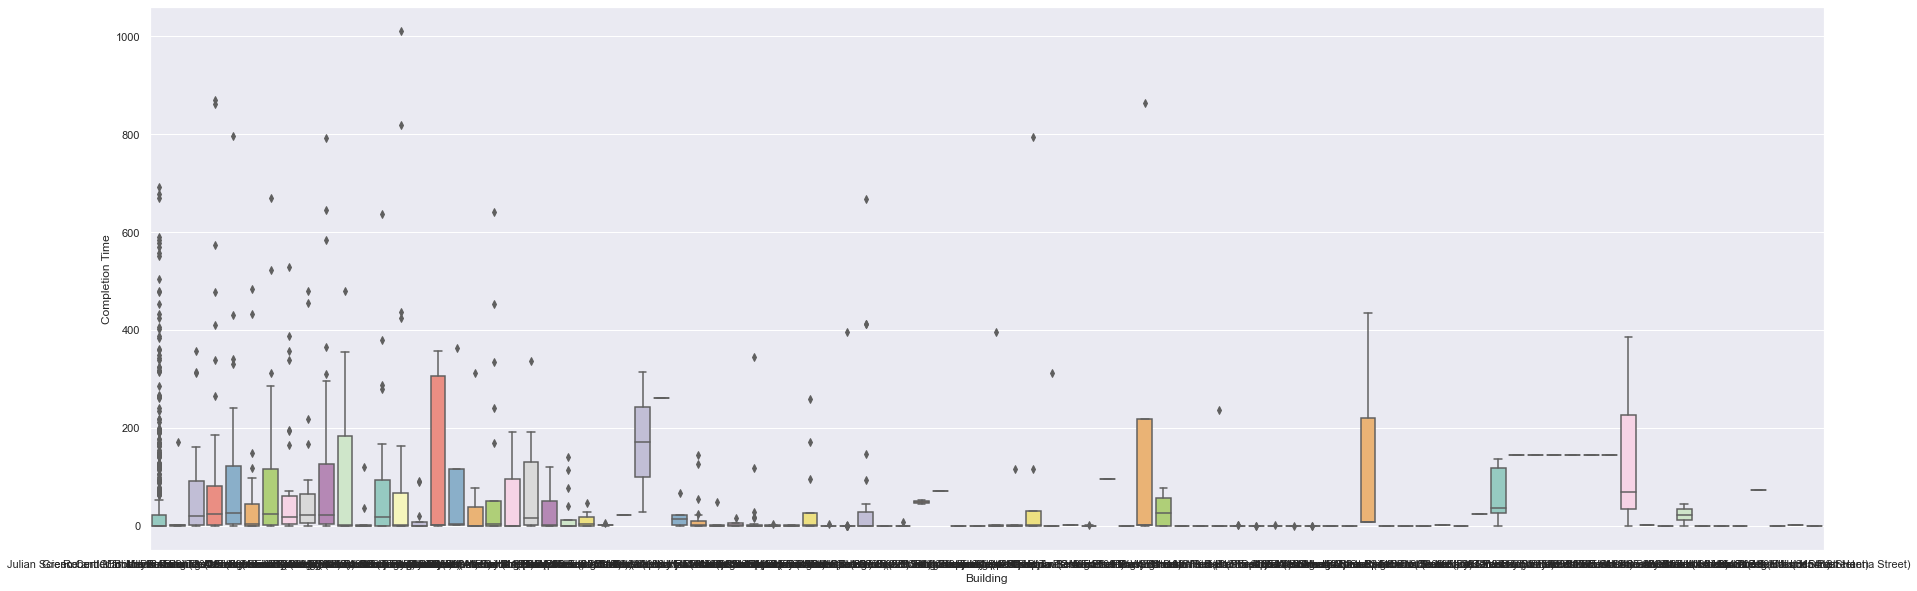

In [604]:
sns.boxplot(x='Building', y='Completion Time', data=famistix_df_neat, palette='Set3')
sns.set(rc={"figure.figsize":(50,10)}) 
plt.show()

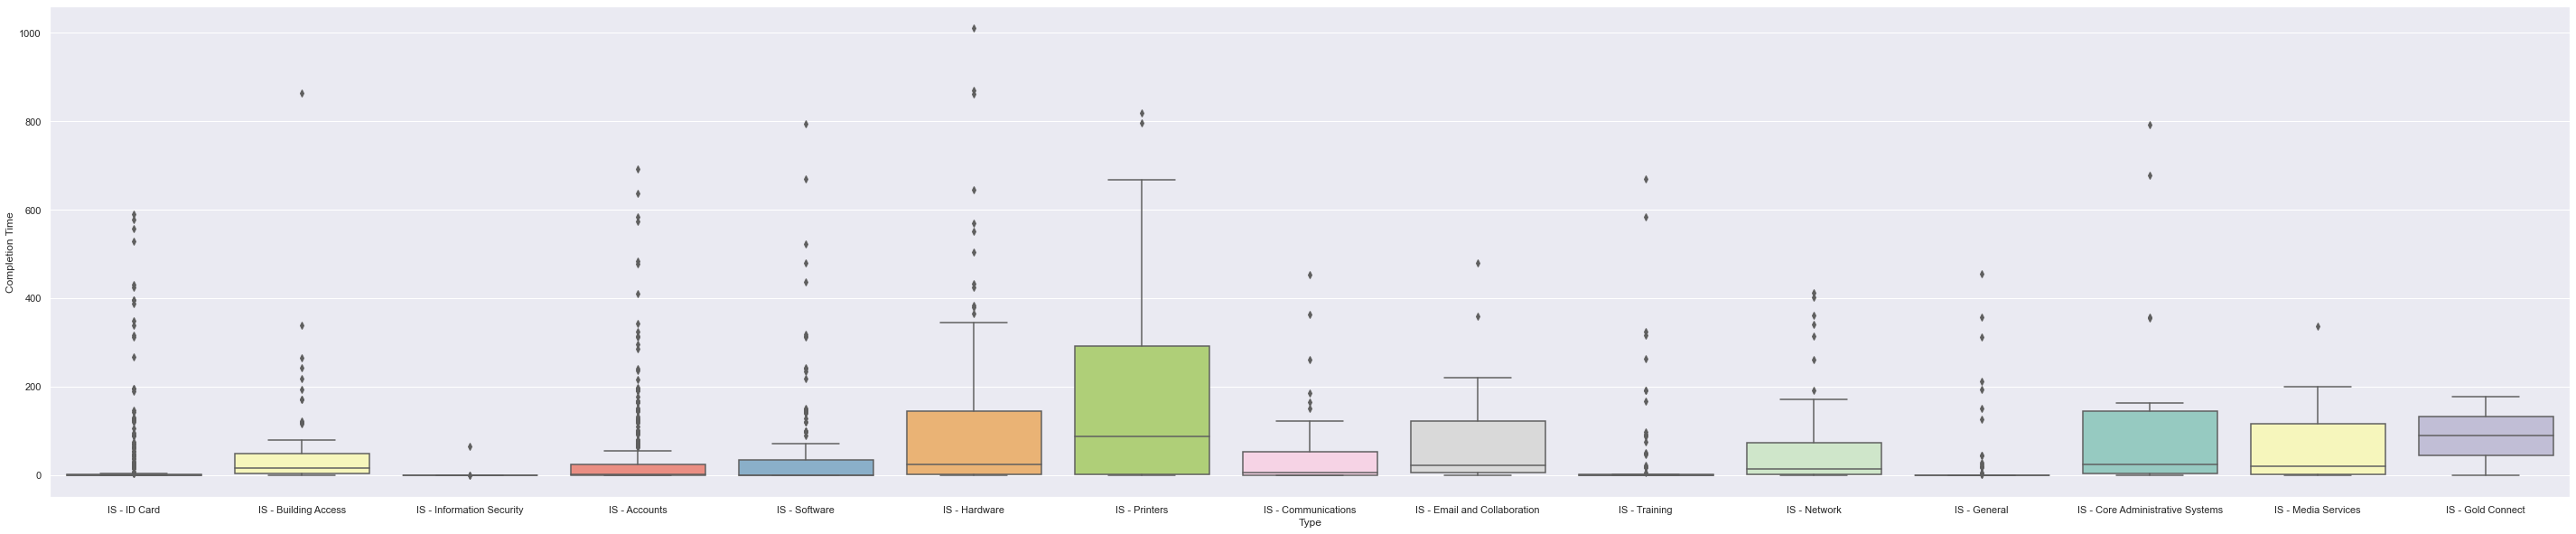

In [605]:
sns.boxplot(x='Type', y='Completion Time', data=famistix_df_neat, palette='Set3')
sns.set(rc={"figure.figsize":(50, 10)}) 
plt.show()

IS - Hardware, IS - Printers and IS - Core types take longer time to complete a request. 

We would expect there is correlation betwwen SubTypes and Completion Time as well.

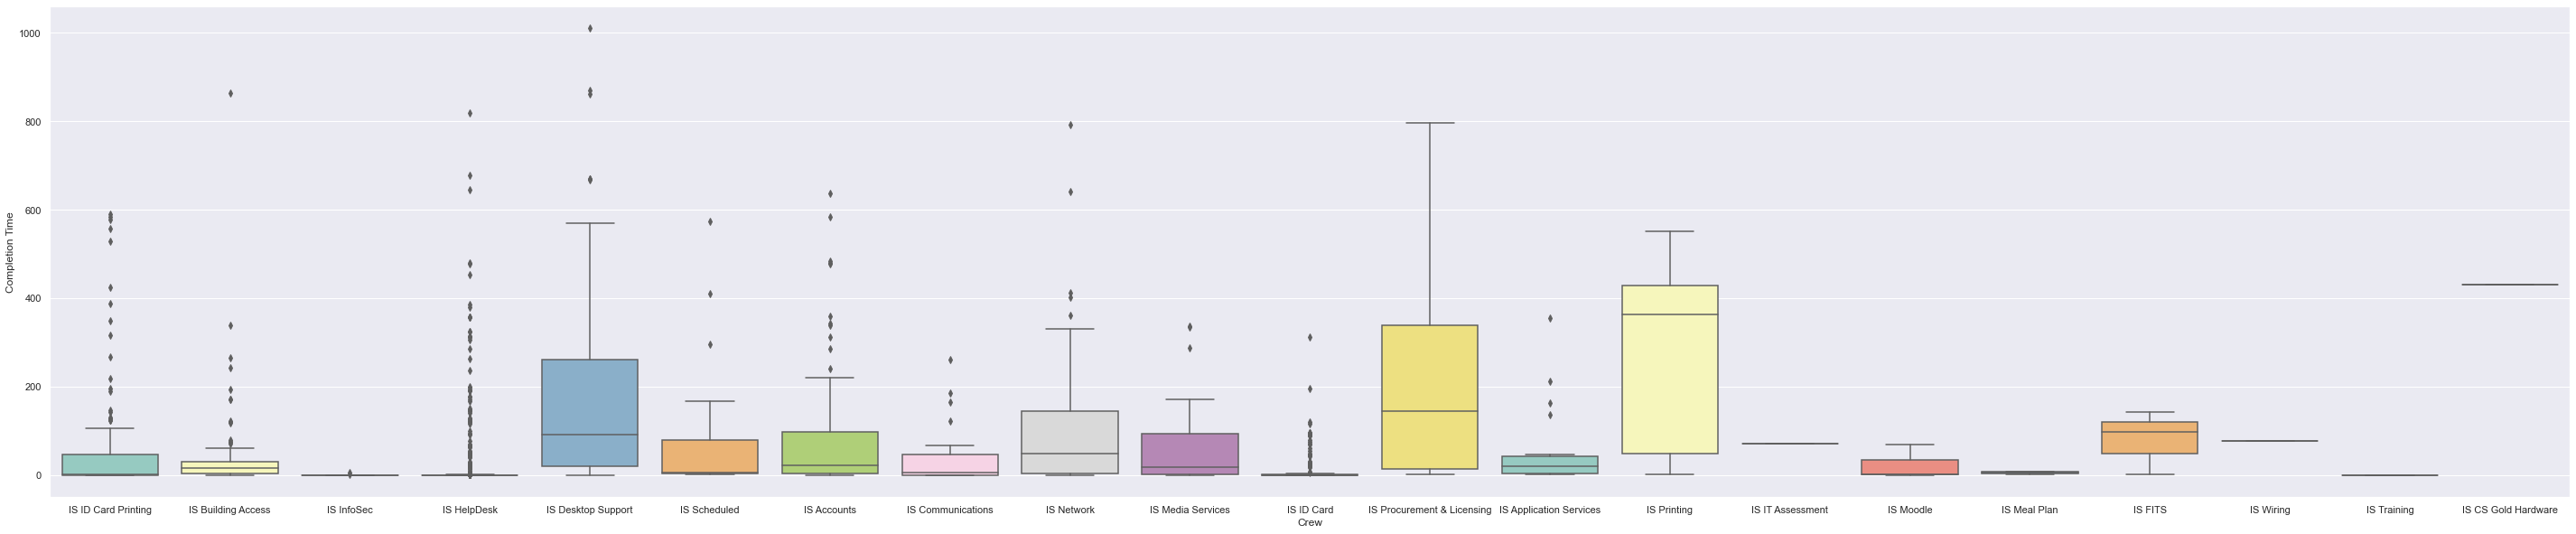

In [606]:
sns.boxplot(x='Crew', y='Completion Time', data=famistix_df_neat, palette='Set3')
sns.set(rc={"figure.figsize":(50, 10)}) 
plt.show()

IS Printing, IS Desktop Support and IS Procurement & Licensing crews take longer time to complete a request.

We would expect there is correlation between Assigned To and Completion Time as well.

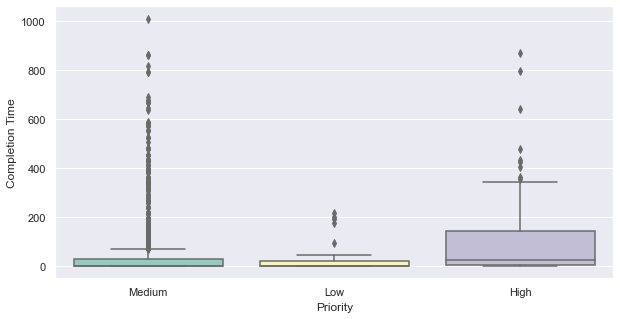

In [623]:
sns.boxplot(x='Priority', y='Completion Time', data=famistix_df_neat, palette='Set3')
sns.set(rc={"figure.figsize":(10, 2)}) 
plt.show()

Surprisingly, it seems that there is a tentative positive correlation between Priority and Completion Time.
The more priority the more time it takes to complete, which seems counterintuitive.

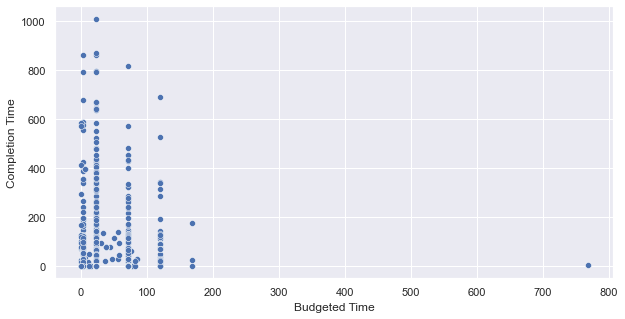

In [629]:
sns.scatterplot(data=famistix_df_neat,x='Budgeted Time',y='Completion Time')
sns.set(rc={"figure.figsize":(10, 2)}) 
plt.show()

There is no clear relationship between Budgeted Time and Completion Time. 

In short, these seven predictors are correlated with the target "Completion Time":
1. "Month"
2. "Building"
3. "Type"
4. "SubType"
5. "Crew"
6. "Assigned To"
7. "Priority"

## Plugging in data and extracting results
A natural concern is to compare average completion time within each category.

In [1753]:
pred_focus_time = input('Input the predictor you want to examine ("MONTH", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): ')

Input the predictor you want to examine ("MONTH", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): Crew


In [1754]:
extract_df_time = famistix_df_neat.groupby([pred_focus_time]).agg({'Completion Time':'mean'}).reset_index()
extract_df_time.rename(columns={'Completion Time':'Average Completion Time'},inplace=True)
print('This is the average completion time of each values in category',pred_focus_time)
extract_df_time

This is the average completion time of each values in category Crew


,Crew,Average Completion Time
0,IS Accounts,74.566667
1,IS Application Services,59.047222
2,IS Building Access,47.326543
3,IS CS Gold Hardware,430.866667
4,IS Communications,43.044444
5,IS Desktop Support,172.549676
6,IS FITS,80.144444
7,IS HelpDesk,25.567699
8,IS ID Card,13.780587
9,IS ID Card Printing,62.479730


Another natural concern is to see the distribution of completion time "bins" across a specific category/sub-category.

In [1749]:
pred_focus_timebin = input('Input the predictor you want to examine ("MONTH", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): ')

Input the predictor you want to examine ("MONTH", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): Assigned To


In [1750]:
famistix_df_neatbin[pred_focus_timebin] = famistix_df_neatbin[pred_focus_timebin].astype(str)
np.unique(famistix_df_neatbin[pred_focus_timebin])

array(['Application Services', 'Arrington', 'Bossnack', 'Carpenter', 'Carter', 'Desktop Support', 'Dugan', 'Feuquay', 'HelpDesk', 'Hughes', 'ID Card', 'IS Help Desk User Email Group', 'Kim',
       'Martin', 'Media Services', 'Miller', 'Moodle', 'Network Team', 'Nguyen', 'Nuss', 'Osmialowski', 'Parrish', 'Pritchard', 'Puckett', 'Smith', 'Timberman', 'Weber-Brueggeman', 'Wilson'],
      dtype=object)

In [1751]:
subpred_focus_timebin = input('Input one of the above sub-categories that you want to examine: ')

Input one of the above sub-categories that you want to examine: Puckett


In [1752]:
extract_df_timebin = famistix_df_neatbin[(famistix_df_neatbin[pred_focus_timebin] == subpred_focus_timebin)].groupby(['Completion Time CAT']).agg({'Request ID':'count'}).reset_index()
extract_df_timebin.rename(columns={'Request ID':'Count'},inplace=True)
extract_df_timebin['Percentage'] = extract_df_timebin[['Count']]/extract_df_timebin[['Count']].sum()*100
print('This is the completion time distribution of sub-category',subpred_focus_timebin,'in',pred_focus_timebin)
print(extract_df_timebin[['Count']].sum())
extract_df_timebin

This is the completion time distribution of sub-category Puckett in Assigned To
Count    31
dtype: int64


,Completion Time CAT,Count,Percentage
0,Very Short,4,12.903226
1,Short,1,3.225806
2,Low Medium,8,25.806452
3,High Medium,11,35.483871
4,Long,7,22.580645


## Modelling

### Appending a testing row and converting categorical data to dummies 

In [38]:
ctime_month_input = input('Input month: ')
ctime_building_input = input('Input building: ')
ctime_type_input = input('Input type: ')
ctime_subtype_input = input('Input subtype: ')
ctime_crew_input = input('Input crew: ')
ctime_assigned_to_input = input('Input assigned to: ')
ctime_priority_input = input('Input priority: ')

Input month: 12
Input building: Julian Science and Mathematics Center (2 East Hanna Street)
Input type: IS - Core Administrative Systems
Input subtype: e-Services
Input crew: IS Application Services
Input assigned to: Dugan
Input priority: Medium


In [39]:
ctime_input_df = pd.DataFrame({'MONTH':[ctime_month_input],'Building':[ctime_building_input],'Type':[ctime_type_input],'SubType':[ctime_subtype_input],
                         'Crew':[ctime_crew_input],'Assigned To':[ctime_assigned_to_input],'Priority':[ctime_priority_input]})
famistix_df_neatbinnew = pd.concat([famistix_df_neatbin, ctime_input_df]).reset_index(drop=True)
famistix_df_neatbinnew

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time,Completion Time CAT
0,1.0,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667,Long
1,2.0,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000,Long
2,3.0,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667,Long
3,4.0,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000,Very Short
4,5.0,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667,Very Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,1898.0,10,10/18/2021 10:28,Annie Weltz,Pulliam Center for Contemporary Media (609 Sou...,IS - Software,Consultation,IS HelpDesk,Pritchard,Medium,10/19/2021 10:28,10/18/2021 10:31,10/18/2021 10:29,24.0,0.016667,Very Short
1536,1899.0,10,10/18/2021 11:41,Anthony Perez,Emison Building (204 East Seminary Street),IS - Accounts,Modify,IS HelpDesk,Pritchard,Medium,10/19/2021 11:41,10/18/2021 11:47,10/18/2021 11:45,24.0,0.066667,Very Short
1537,1900.0,10,10/18/2021 11:56,Eric Motycka,Robert G. Bottoms Alumni & Development Center ...,IS - Information Security,"Spam, Phishing �",IS HelpDesk,HelpDesk,Medium,10/18/2021 12:56,10/18/2021 11:57,10/18/2021 11:56,1.0,0.000000,Very Short
1538,1901.0,10,10/18/2021 12:00,John Schuller,Vernon E. Jordan Jr. Hall (220 East Olive Street),IS - General,Other,IS HelpDesk,HelpDesk,Medium,10/19/2021 12:00,10/18/2021 12:01,10/18/2021 12:00,24.0,0.000000,Very Short


In [40]:
dummies2 = pd.get_dummies(famistix_df_neatbinnew['MONTH'])
famistix_df_model2 = pd.concat([famistix_df_neatbinnew, dummies2], axis='columns')

dummies2 = pd.get_dummies(famistix_df_neatbinnew['Building'])
famistix_df_model2 = pd.concat([famistix_df_model2, dummies2], axis = 'columns')

dummies2 = pd.get_dummies(famistix_df_neatbinnew['Type'])
famistix_df_model2 = pd.concat([famistix_df_model2, dummies2], axis = 'columns')

dummies2 = pd.get_dummies(famistix_df_neatbinnew['SubType'])
famistix_df_model2 = pd.concat([famistix_df_model2, dummies2], axis = 'columns')

dummies2 = pd.get_dummies(famistix_df_neatbinnew['Crew'])
famistix_df_model2 = pd.concat([famistix_df_model2, dummies2], axis = 'columns')

dummies2 = pd.get_dummies(famistix_df_neatbinnew['Assigned To'])
famistix_df_model2 = pd.concat([famistix_df_model2, dummies2], axis = 'columns')

dummies2 = pd.get_dummies(famistix_df_neatbinnew['Priority'])
famistix_df_model2 = pd.concat([famistix_df_model2, dummies2], axis = 'columns')

ctime_testing_row = famistix_df_model2.iloc[[len(famistix_df_model2)-1],:]
famistix_df_model2 = famistix_df_model2.iloc[:-1 , :]
famistix_df_model2.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,...,Parrish,Pritchard,Puckett,Smith,Timberman,Weber-Brueggeman,Wilson,High,Low,Medium
0,1.0,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,...,0,0,0,0,0,0,0,0,0,1
1,2.0,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,...,0,0,0,0,0,0,0,0,0,1
2,3.0,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,...,0,0,0,0,0,0,0,0,0,1
3,4.0,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,...,0,0,0,0,0,0,0,0,0,1
4,5.0,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,nan,ID Card,Medium,...,0,0,0,0,0,0,0,0,0,1


### Using LabelEncoder to encode target variable

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 

le.fit(famistix_df_model2['Completion Time CAT'])  
print(le.classes_) 

famistix_df_model2['Completion Time CAT Encoded'] = le.transform(famistix_df_model2['Completion Time CAT']) 

['High Medium' 'Long' 'Low Medium' 'Short' 'Very Short']


### Creating dictionaries to look up the outcomes

In [42]:
famistix_df_model2_lookup = dict(zip(famistix_df_model2['Completion Time CAT'].unique(), famistix_df_model2['Completion Time CAT Encoded'].unique()))  
famistix_df_model2_lookup

{'Long': 1, 'Very Short': 4, 'Low Medium': 2, 'Short': 3, 'High Medium': 0}

In [43]:
famistix_df_model2_lookupreverse = dict(zip(famistix_df_model2['Completion Time CAT Encoded'].unique(), famistix_df_model2['Completion Time CAT'].unique()))  
famistix_df_model2_lookupreverse

{1: 'Long', 4: 'Very Short', 2: 'Low Medium', 3: 'Short', 0: 'High Medium'}

### Implementing models and checking coefficients

The code below runs every possible logistic regression models at the same time (a model comprising one predictor and our target "Completion Time CAT Encoded"). It checks statistical significance with significance level 0.05. The code may take a long time to run so be patient.

In [1725]:
from sklearn.linear_model import LogisticRegression

predictor=[]
model=[]
X_list=[]

for i in range(16,214):
    X = famistix_df_model2.iloc[:,[i]]
    y = famistix_df_model2['Completion Time CAT Encoded']
    predictor=predictor+list([X.columns])
    X_list = X_list + list([X])
    lr = LogisticRegression(C=1e30, solver='lbfgs', multi_class='multinomial', random_state=1)
    model = model + list([lr.fit(X,y)])
    
ctime_df = pd.DataFrame(predictor,columns=['predictor'])
ctime_df['model'] = pd.Series(model)
ctime_df['X'] = pd.Series(X_list)

for i in list(famistix_df_model2_lookup.keys()):
    CAT = famistix_df_model2_lookup[i]
    ctime_df['raw intercept '+i] = [j.intercept_[CAT] for j in ctime_df['model']]
    ctime_df['pvalue intercept '+i] = [logit_pvalue(j,k,CAT)[0] for (j,k) in zip(ctime_df['model'],ctime_df['X'])] 
    ctime_df['raw coefficient '+i] = [j.coef_[CAT][0] for j in ctime_df['model']]
    ctime_df['pvalue coefficient '+i] = [logit_pvalue(j,k,CAT)[1] for (j,k) in zip(ctime_df['model'],ctime_df['X'])]
    
ctime_df = ctime_df[(ctime_df['pvalue coefficient Very Short'] < 0.05) | (ctime_df['pvalue coefficient Short'] < 0.05) | 
                      (ctime_df['pvalue coefficient Low Medium'] < 0.05) | (ctime_df['pvalue coefficient High Medium'] < 0.05) | (ctime_df['pvalue coefficient Long'] < 0.05)]
ctime_df.drop(['model','X'],axis='columns',inplace=True)
ctime_df.reset_index(drop=True)

,predictor,raw intercept Long,pvalue intercept Long,raw coefficient Long,pvalue coefficient Long,raw intercept Very Short,pvalue intercept Very Short,raw coefficient Very Short,pvalue coefficient Very Short,raw intercept Low Medium,...,raw coefficient Low Medium,pvalue coefficient Low Medium,raw intercept Short,pvalue intercept Short,raw coefficient Short,pvalue coefficient Short,raw intercept High Medium,pvalue intercept High Medium,raw coefficient High Medium,pvalue coefficient High Medium
0,Center for Diversity & Inclusion (5 West Hanna ),-0.514466,0.051845,6.485252,1.314538e-03,1.218048,0.000004,5.669765,4.972721e-03,-0.420408,...,-7.076673,4.552776e-04,0.150093,0.570528,-10.788933,9.050384e-08,-0.433267,0.101520,5.710590,4.669076e-03
1,East College (400 South Locust Street),-0.524103,0.048839,3.090330,9.044864e-02,1.221361,0.000004,1.752835,3.369094e-01,-0.415845,...,-8.179670,7.421452e-06,0.147371,0.579622,1.728152,3.437573e-01,-0.428785,0.107024,1.608354,3.782443e-01
2,Phi Kappa Psi,-0.508648,0.053736,5.722010,4.395317e-02,1.215715,0.000004,5.789817,4.150897e-02,-0.421501,...,-6.687475,1.855031e-02,0.148977,0.572093,-10.473393,2.266039e-04,-0.434543,0.099367,5.649041,4.671808e-02
3,Service Center (300 West Hill Street),-0.508849,0.053855,4.894521,2.976121e-02,1.220379,0.000004,3.858256,8.668785e-02,-0.421874,...,-17.815276,2.664535e-15,0.145084,0.582513,4.242149,5.962057e-02,-0.434741,0.099514,4.820350,3.232885e-02
4,Studebaker Building (313 South Locust Street),-0.490901,0.083992,0.091488,8.969138e-01,1.287194,0.000006,-1.686863,1.690087e-02,-0.398976,...,-0.118360,8.668855e-01,0.100999,0.722202,0.767838,2.768704e-01,-0.498315,0.079417,0.945897,1.803964e-01
5,IS - Hardware,-0.556471,0.060142,0.534430,3.517582e-01,1.302685,0.000011,-1.197112,3.699385e-02,-0.404637,...,-0.069521,9.035861e-01,0.128477,0.664293,0.284650,6.199156e-01,-0.470055,0.112323,0.447553,4.355026e-01
6,IS - Printers,-0.619803,0.035417,1.295160,1.968469e-02,1.271854,0.000016,-0.870787,1.168578e-01,-0.408469,...,0.062279,9.107041e-01,0.199503,0.498346,-0.951211,8.672626e-02,-0.443085,0.132636,0.464559,4.028339e-01
7,Box,-0.503418,0.058681,2.508281,8.115068e-02,1.228305,0.000004,-11.322613,3.552714e-15,-0.422818,...,2.425504,9.170104e-02,0.146904,0.581156,2.549689,7.625520e-02,-0.448974,0.091774,3.839138,7.598352e-03
8,Canon or Network,-0.596018,0.037763,1.273936,3.808614e-02,1.255684,0.000012,-0.683233,2.660168e-01,-0.405742,...,-0.120563,8.443972e-01,0.185750,0.517352,-0.894329,1.454093e-01,-0.439675,0.125402,0.424190,4.898372e-01
9,Distribution Lists,-0.498398,0.061597,2.215542,1.908819e-01,1.233327,0.000004,-11.655735,5.938583e-12,-0.417818,...,2.135083,2.074983e-01,0.133490,0.616625,3.528660,3.723378e-02,-0.450601,0.091041,3.776450,2.578216e-02


In [1726]:
for i in list(famistix_df_model2_lookup.keys()):
    ctime_df['intercept '+i] = [j if k < 0.05 else 0 for (j,k) in zip(ctime_df['raw intercept '+i], ctime_df['pvalue intercept '+i])]
    ctime_df['coefficient '+i] = [j if k < 0.05 else 0 for (j,k) in zip(ctime_df['raw coefficient '+i], ctime_df['pvalue coefficient '+i])]
for i in list(famistix_df_model2_lookup.keys()):
    ctime_df.drop(['raw coefficient '+i,'pvalue coefficient '+i],axis='columns',inplace=True)
    ctime_df.drop(['raw intercept '+i,'pvalue intercept '+i],axis='columns',inplace=True)
ctime_df = ctime_df.reset_index(drop=True)
ctime_df

,predictor,intercept Long,coefficient Long,intercept Very Short,coefficient Very Short,intercept Low Medium,coefficient Low Medium,intercept Short,coefficient Short,intercept High Medium,coefficient High Medium
0,Center for Diversity & Inclusion (5 West Hanna ),0.000000,6.485252,1.218048,5.669765,0,-7.076673,0,-10.788933,0,5.710590
1,East College (400 South Locust Street),-0.524103,0.000000,1.221361,0.000000,0,-8.179670,0,0.000000,0,0.000000
2,Phi Kappa Psi,0.000000,5.722010,1.215715,5.789817,0,-6.687475,0,-10.473393,0,5.649041
3,Service Center (300 West Hill Street),0.000000,4.894521,1.220379,0.000000,0,-17.815276,0,0.000000,0,4.820350
4,Studebaker Building (313 South Locust Street),0.000000,0.000000,1.287194,-1.686863,0,0.000000,0,0.000000,0,0.000000
5,IS - Hardware,0.000000,0.000000,1.302685,-1.197112,0,0.000000,0,0.000000,0,0.000000
6,IS - Printers,-0.619803,1.295160,1.271854,0.000000,0,0.000000,0,0.000000,0,0.000000
7,Box,0.000000,0.000000,1.228305,-11.322613,0,0.000000,0,0.000000,0,3.839138
8,Canon or Network,-0.596018,1.273936,1.255684,0.000000,0,0.000000,0,0.000000,0,0.000000
9,Distribution Lists,0.000000,0.000000,1.233327,-11.655735,0,0.000000,0,3.528660,0,3.776450


In [1729]:
ctime_main_df = pd.DataFrame()
for i in list(famistix_df_model2_lookup.keys()):
    ctime_main_df[i] = ["{:,.2f}".format(e**(j1+j2)*100/(e**(j3+j4)+e**(j5+j6)+e**(j7+j8)+e**(j9+j10)+e**(j11+j12))) for (j1,j2,j3,j4,j5,j6,j7,j8,j9,j10,j11,j12) in zip(ctime_df['intercept '+i],ctime_df['coefficient '+i],ctime_df['intercept High Medium'],ctime_df['coefficient High Medium'],ctime_df['intercept Long'], ctime_df['coefficient Long'], ctime_df['intercept Low Medium'],ctime_df['coefficient Low Medium'],ctime_df['intercept Short'],ctime_df['coefficient Short'],ctime_df['intercept Very Short'],ctime_df['coefficient Very Short'])]
ctime_main_df['Predictor'] = pd.Series(ctime_df['predictor'])
ctime_main_df['Observation'] = 'Appear'
    
ctime_append_df = pd.DataFrame()
for i in list(famistix_df_model2_lookup.keys()):
    ctime_append_df[i] = ["{:,.2f}".format(e**(j1)*100/(e**(j2)+e**(j3)+e**(j4)+e**(j5)+e**(j6))) for (j1,j2,j3,j4,j5,j6) in zip(ctime_df['intercept '+i],ctime_df['intercept High Medium'],ctime_df['intercept Long'],ctime_df['intercept Low Medium'],ctime_df['intercept Short'],ctime_df['intercept Very Short'])]
ctime_append_df['Predictor'] = pd.Series(ctime_df['predictor'])
ctime_append_df['Observation'] = 'Gone'

ctime_combine_df = pd.concat([ctime_main_df,ctime_append_df])

ctime_combine_df['Category'] = ['MONTH' if np.isin(x,famistix_df_neatbin['MONTH']) else
                        'Building' if np.isin(x,famistix_df_neatbin['Building']) else
                        'Type' if np.isin(x,famistix_df_neatbin['Type']) else
                        'SubType' if np.isin(x,famistix_df_neatbin['SubType']) else
                        'Crew' if np.isin(x,famistix_df_neatbin['Crew']) else
                        'Assigned To' if np.isin(x,famistix_df_neatbin['Assigned To']) else
                        'Priority' if np.isin(x,famistix_df_neatbin['Priority']) else
                        None for x in ctime_combine_df['Predictor']]
ctime_combine_df

,Long,Very Short,Low Medium,Short,High Medium,Predictor,Observation,Category
0,33.82,50.59,0.00,0.00,15.59,Center for Diversity & Inclusion (5 West Hanna ),Appear,Building
1,9.89,56.68,0.00,16.71,16.71,East College (400 South Locust Street),Appear,Building
2,18.05,65.16,0.00,0.00,16.78,Phi Kappa Psi,Appear,Building
3,50.98,1.29,0.00,0.38,47.34,Service Center (300 West Hill Street),Appear,Building
4,21.41,14.36,21.41,21.41,21.41,Studebaker Building (313 South Locust Street),Appear,Building
5,19.56,21.74,19.56,19.56,19.56,IS - Hardware,Appear,Type
6,23.03,41.81,11.72,11.72,11.72,IS - Printers,Appear,Type
7,2.02,0.00,2.02,2.02,93.94,Box,Appear,SubType
8,23.23,41.39,11.79,11.79,11.79,Canon or Network,Appear,SubType
9,1.25,0.00,1.25,42.74,54.75,Distribution Lists,Appear,SubType


In [1730]:
ctime_result_df = ctime_combine_df.melt(id_vars=['Predictor','Observation','Category'], value_vars=['High Medium','Long','Low Medium','Short','Very Short'])
ctime_result_df = ctime_result_df.rename(columns={'variable':'Ctime','value':'Expected Probability'})
ctime_result_df

,Predictor,Observation,Category,Ctime,Expected Probability
0,Center for Diversity & Inclusion (5 West Hanna ),Appear,Building,High Medium,15.59
1,East College (400 South Locust Street),Appear,Building,High Medium,16.71
2,Phi Kappa Psi,Appear,Building,High Medium,16.78
3,Service Center (300 West Hill Street),Appear,Building,High Medium,47.34
4,Studebaker Building (313 South Locust Street),Appear,Building,High Medium,21.41
...,...,...,...,...,...
255,Osmialowski,Gone,Assigned To,Very Short,48.68
256,Puckett,Gone,Assigned To,Very Short,46.62
257,Timberman,Gone,Assigned To,Very Short,46.35
258,Wilson,Gone,Assigned To,Very Short,46.38


In [1731]:
ctime_result_df.to_csv('Predictor and Logistic Probability for Ctime.csv', index=False)

In [1745]:
ctime_check_df = famistix_df_neatbin.melt(id_vars=['Request ID','Completion Time CAT'], value_vars=['MONTH','Building','Type','SubType','Crew','Assigned To','Priority'])
ctime_check_df = ctime_check_df.rename(columns={'variable':'Category','value':'Predictor','Completion Time CAT':'ctime'})
ctime_check_df['Predictor'] = ctime_check_df['Predictor'].astype(str)
ctime_check_df

,Request ID,ctime,Category,Predictor
0,1,Long,MONTH,8
1,2,Long,MONTH,8
2,3,Long,MONTH,8
3,4,Very Short,MONTH,8
4,5,Very Short,MONTH,8
...,...,...,...,...
10768,1897,Very Short,Priority,Medium
10769,1898,Very Short,Priority,Medium
10770,1899,Very Short,Priority,Medium
10771,1900,Very Short,Priority,Medium


In [1746]:
ctime_check_df.to_csv('Predictor for Ctime.csv',index=False)

## Interpreting results
If we focus on the outcome "Long" (CAT = 1), for example, a request that is from "Service Center (300 West Hill Street)" or belongs to "Local" subtype will be more likely to be "Long", because coefficient is highly positive. We can go to the second subsection ("Plugging in data and extracting results") to check. We can also change the outcome (and hence the CAT) according to our curiosity.

## Predicting completion time

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.5, solver='lbfgs', multi_class='multinomial', max_iter=1000000, random_state=1)
X = famistix_df_model2.iloc[:,16:214]
y = famistix_df_model2['Completion Time CAT Encoded']
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1, stratify=y)
lr.fit(X_train, y_train)
print('Training accuracy:', lr.score(X_train, y_train))
print('Test accuracy:', lr.score(X_test, y_test))

Training accuracy: 0.7047353760445683
Test accuracy: 0.6645021645021645


In [45]:
pred = lr.predict(ctime_testing_row.iloc[:,16:214])[0]
print('Completion time prediction for testing row:\n', famistix_df_model2_lookupreverse[pred])
print('Probability prediction for testing row:\n', lr.predict_proba(ctime_testing_row.iloc[:,16:214])[0])
print('Column order:\n',famistix_df_model2_lookupreverse)

Completion time prediction for testing row:
 Short
Probability prediction for testing row:
 [0.14780333 0.18031846 0.1301552  0.38643628 0.15528673]
Column order:
 {1: 'Long', 4: 'Very Short', 2: 'Low Medium', 3: 'Short', 0: 'High Medium'}


# Timeliness Insights

## Chi-squared contingency

In [3093]:
var1_timely=('MONTH', 'Initiated By','Building','Type','SubType','Crew','Assigned To','Priority')
var2_timely=("Timeliness",)
varprod_timely = list(product(var2_timely, var1_timely))
varprod_timely

[('Timeliness', 'MONTH'),
 ('Timeliness', 'Initiated By'),
 ('Timeliness', 'Building'),
 ('Timeliness', 'Type'),
 ('Timeliness', 'SubType'),
 ('Timeliness', 'Crew'),
 ('Timeliness', 'Assigned To'),
 ('Timeliness', 'Priority')]

In [3094]:
result= []
for i in varprod_timely:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
                            famistix_df_timely[i[0]], famistix_df_timely[i[1]])))[1]))
        
result

[('Timeliness', 'MONTH', 0.030245248053077895),
 ('Timeliness', 'Initiated By', 0.0012965064364614922),
 ('Timeliness', 'Building', 2.262728492089194e-19),
 ('Timeliness', 'Type', 2.4760060310941802e-39),
 ('Timeliness', 'SubType', 2.861239506414476e-60),
 ('Timeliness', 'Crew', 3.7161843942478417e-75),
 ('Timeliness', 'Assigned To', 3.5622162337225365e-62),
 ('Timeliness', 'Priority', 1.6068416811920823e-05)]

In [2998]:
chi_test_output_timely = pd.DataFrame(result, columns = ['var1_timely', 'var2_timely', 'coeff'])
chi_test_output_timely.pivot(index='var1_timely', columns='var2_timely', values='coeff')

var2_timely,Assigned To,Building,Crew,Initiated By,MONTH,Priority,SubType,Type
var1_timely,,,,,,,,
Timeliness,3.562216e-62,2.262728e-19,3.716184e-75,0.001297,0.030245,0.000016,2.861240e-60,2.476006e-39


In short, these eight predictors are correlated with the target "Timeliness":
1. "MONTH"
2. "Initiated By"
3. "Building"
4. "Type"
5. "SubType"
6. "Crew"
7. "Assigned To"
8. "Priority".

## Plugging in data and extracting results
A natural concern is to see the distribution of timeliness across a specific category/sub-category.

In [115]:
pred_focus_timely = input('Input the predictor you want to examine ("MONTH", "Initiated By", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): ')

Input the predictor you want to examine ("MONTH", "Initiated By", "Building", "Type", "SubType", "Crew", "Assigned To", or "Priority"): Crew


In [116]:
famistix_df_timely[pred_focus_timely] = famistix_df_timely[pred_focus_timely].astype(str)
np.unique(famistix_df_timely[pred_focus_timely])

array(['IS Accounts', 'IS Application Services', 'IS Building Access', 'IS CS Gold Hardware', 'IS Communications', 'IS Desktop Support', 'IS FITS', 'IS HelpDesk', 'IS ID Card', 'IS ID Card Printing',
       'IS IT Assessment', 'IS InfoSec', 'IS Meal Plan', 'IS Media Services', 'IS Moodle', 'IS Network', 'IS Printing', 'IS Procurement & Licensing', 'IS Scheduled', 'IS Training', 'IS Wiring',
       'nan'], dtype=object)

In [118]:
subpred_focus_timely = input('Input one of the above sub-categories that you want to examine: ')

Input one of the above sub-categories that you want to examine: IS Scheduled


In [119]:
extract_df_timely= famistix_df_timely[(famistix_df_timely[pred_focus_timely] == subpred_focus_timely)].groupby(['Timeliness']).agg({'Request ID':'count'}).reset_index()
extract_df_timely.rename(columns={'Request ID':'Count'},inplace=True)
extract_df_timely['Percentage'] = extract_df_timely[['Count']]/extract_df_timely[['Count']].sum()*100
print('This is the timeliness distribution of sub-category',subpred_focus_timely,'in',pred_focus_timely)
print(extract_df_timely[['Count']].sum())
extract_df_timely

This is the timeliness distribution of sub-category IS Scheduled in Crew
Count    50
dtype: int64


,Timeliness,Count,Percentage
0,Late,49,98.0
1,On-time,1,2.0


## Modelling

### Appending a testing row and converting categorical data to dummies 

In [313]:
timely_month_input = input('Input month: ')
timely_initiated_by_input = input('Input initiated by: ')
timely_building_input = input('Input building: ')
timely_type_input = input('Input type: ')
timely_subtype_input = input('Input subtype: ')
timely_crew_input = input('Input crew: ')
timely_assigned_to_input = input('Input assigned to: ')
timely_priority_input = input('Input priority: ')

Input month: 9
Input initiated by: Zaida Benassi
Input building: Robert G. Bottoms Alumni & Development Center (201 East Seminary Street)
Input type: IS - Building Access
Input subtype: Modify rights
Input crew: IS Building Access
Input assigned to: Arrington
Input priority: High


In [314]:
timely_input_df = pd.DataFrame({'MONTH':[timely_month_input],'Initiated By':[timely_initiated_by_input],'Building':[timely_building_input],'Type':[timely_type_input],'SubType':[timely_subtype_input],
                         'Crew':[timely_crew_input],'Assigned To':[timely_assigned_to_input],'Priority':[timely_priority_input]})
famistix_df_timelynew = pd.concat([famistix_df_timely, timely_input_df]).reset_index(drop=True)
famistix_df_timelynew

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,Complete By,Last Updated Date,Act. Complete Date,Budgeted Time,Completion Time,Timeliness
0,1.0,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:31,8/25/2021 13:03,8/25/2021 13:02,3.0,557.516667,Late
1,2.0,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,8/2/2021 10:32,8/26/2021 21:15,8/26/2021 21:14,3.0,589.700000,Late
2,3.0,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,8/2/2021 10:44,8/9/2021 10:35,8/9/2021 10:33,3.0,170.816667,Late
3,4.0,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,8/2/2021 9:10,8/2/2021 8:11,8/2/2021 8:10,1.0,0.000000,On-time
4,5.0,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,NaN,ID Card,Medium,8/5/2021 8:37,8/2/2021 8:39,8/2/2021 8:38,72.0,0.016667,On-time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,1898.0,10,10/18/2021 10:28,Annie Weltz,Pulliam Center for Contemporary Media (609 Sou...,IS - Software,Consultation,IS HelpDesk,Pritchard,Medium,10/19/2021 10:28,10/18/2021 10:31,10/18/2021 10:29,24.0,0.016667,On-time
1536,1899.0,10,10/18/2021 11:41,Anthony Perez,Emison Building (204 East Seminary Street),IS - Accounts,Modify,IS HelpDesk,Pritchard,Medium,10/19/2021 11:41,10/18/2021 11:47,10/18/2021 11:45,24.0,0.066667,On-time
1537,1900.0,10,10/18/2021 11:56,Eric Motycka,Robert G. Bottoms Alumni & Development Center ...,IS - Information Security,"Spam, Phishing �",IS HelpDesk,HelpDesk,Medium,10/18/2021 12:56,10/18/2021 11:57,10/18/2021 11:56,1.0,0.000000,On-time
1538,1901.0,10,10/18/2021 12:00,John Schuller,Vernon E. Jordan Jr. Hall (220 East Olive Street),IS - General,Other,IS HelpDesk,HelpDesk,Medium,10/19/2021 12:00,10/18/2021 12:01,10/18/2021 12:00,24.0,0.000000,On-time


In [315]:
dummies3 = pd.get_dummies(famistix_df_timelynew['MONTH'])
famistix_df_model3 = pd.concat([famistix_df_timelynew, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['Initiated By'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['Building'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['Type'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['SubType'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['Crew'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['Assigned To'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

dummies3 = pd.get_dummies(famistix_df_timelynew['Priority'])
famistix_df_model3 = pd.concat([famistix_df_model3, dummies3], axis='columns')

timely_testing_row = famistix_df_model3.iloc[[len(famistix_df_model3)-1],:]
famistix_df_model3 = famistix_df_model3.iloc[:-1 , :]
famistix_df_model3.head()

,Request ID,MONTH,Date,Initiated By,Building,Type,SubType,Crew,Assigned To,Priority,...,Parrish,Pritchard,Puckett,Smith,Timberman,Weber-Brueggeman,Wilson,High,Low,Medium
0,1.0,8,8/2/2021 7:31,Hieu Le,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,...,0,0,0,0,0,0,0,0,0,1
1,2.0,8,8/2/2021 7:32,Emmanuel Duah,Julian Science and Mathematics Center (2 East ...,IS - ID Card,Replace,IS ID Card Printing,HelpDesk,Medium,...,0,0,0,0,0,0,0,0,0,1
2,3.0,8,8/2/2021 7:44,Cristina Osmialowski,Phi Delta Theta,IS - Building Access,Modify rights,IS Building Access,Arrington,Medium,...,0,0,0,0,0,0,0,0,0,1
3,4.0,8,8/2/2021 8:10,Evan Steffy,Julian Science and Mathematics Center (2 East ...,IS - Information Security,"Spam, Phishing �",IS InfoSec,Osmialowski,Medium,...,0,0,0,0,0,0,0,0,0,1
4,5.0,8,8/2/2021 8:37,Ian McCullough,Julian Science and Mathematics Center (2 East ...,IS - ID Card,New,NaN,ID Card,Medium,...,0,0,0,0,0,0,0,0,0,1


### Using LabelEncoder to encode target variable

In [316]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 

le.fit(famistix_df_model3['Timeliness'])  
print(le.classes_) 

famistix_df_model3['Timeliness Encoded'] = le.transform(famistix_df_model3['Timeliness']) 

['Late' 'On-time']


### Creating dictionaries to look up the outcomes

In [317]:
famistix_df_model3_lookup = dict(zip(famistix_df_model3['Timeliness'].unique(), famistix_df_model3['Timeliness Encoded'].unique()))  
famistix_df_model3_lookup

{'Late': 0, 'On-time': 1}

In [318]:
famistix_df_model3_lookupreverse = dict(zip(famistix_df_model3['Timeliness Encoded'].unique(), famistix_df_model3['Timeliness'].unique()))  
famistix_df_model3_lookupreverse

{0: 'Late', 1: 'On-time'}

## Predicting timeliness

In [1755]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.5, solver='lbfgs', multi_class='multinomial', max_iter=1000000, random_state=1)
X = famistix_df_model3.iloc[:,16:1054]
y = famistix_df_model3['Timeliness Encoded']
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1, stratify=y)
lr.fit(X_train, y_train)
print('Training accuracy:', lr.score(X_train, y_train))
print('Test accuracy:', lr.score(X_test, y_test))

Training accuracy: 0.8922934076137419
Test accuracy: 0.8225108225108225


In [1756]:
pred = lr.predict(timely_testing_row.iloc[:,16:1054])[0]
print('Timeliness prediction for testing row:\n', famistix_df_model3_lookupreverse[pred])
print('Probability prediction for testing row:\n', lr.predict_proba(timely_testing_row.iloc[:,16:1054])[0])
print('Column order:\n',famistix_df_model3_lookupreverse)

Timeliness prediction for testing row:
 Late
Probability prediction for testing row:
 [0.52818498 0.47181502]
Column order:
 {0: 'Late', 1: 'On-time'}
